<a href="https://colab.research.google.com/github/obliquesignal/algo-trading/blob/master/O'Reilly_Non_linear_ML_Class_Decision_Tree_Classification_and_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Market Data

In [0]:
#Import Python Libraries
import numpy as np
import pandas as pd
from datetime import datetime

import pandas_datareader.data as pdr

import matplotlib.pyplot as plt
plt.style.use('seaborn')

In [0]:
#Import data
start = datetime(1982, 1, 1)
end = datetime(2020, 2, 29)

gdp = pdr.DataReader('A191RL1Q225SBEA', 'fred', start, end) #Annualized percantage change in real GDP from previous quarter
recession = pdr.DataReader('USREC', 'fred', start, end) #NBER business cycle classification
yield_curve = pdr.DataReader('T10Y3MM', 'fred', start, end) #Difference between the 3 month and 10 year treasury yields
unemployment = pdr.DataReader('UNRATE', 'fred', start, end) #Unemployment rate
industrial_capacity = pdr.DataReader('TCU', 'fred', start, end) #Total industrial capacity utilization

In [0]:
#Create classification target dataframe
targetclass = recession[1:] #Feature matrix does not have this data instance
targetclass.head()

,USREC
DATE,
1982-02-01,1
1982-03-01,1
1982-04-01,1
1982-05-01,1
1982-06-01,1


In [0]:
#Create classification features dataframe
features = pd.DataFrame()
features['curve'] = yield_curve['T10Y3MM'].diff()
features['unemployment'] = unemployment['UNRATE'].diff()
features['industrial'] = industrial_capacity['TCU'].diff()
features = features.dropna()
features.head()

,curve,unemployment,industrial
DATE,,,
1982-02-01,-1.52,0.3,1.3279
1982-03-01,0.40,0.1,-0.7318
1982-04-01,-0.02,0.3,-0.8027
1982-05-01,0.38,0.1,-0.6087
1982-06-01,0.31,0.2,-0.3668


# Decision Tree classifier for predicting an economic recession

In [0]:
#Train and test classifier using Gini impurity performance metric
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

classifier = DecisionTreeClassifier(random_state=1)
targetclass = np.ravel(targetclass)

features_train, features_test, targetclass_train, targetclass_test = train_test_split(features, targetclass, test_size = 0.25, random_state=0)
classifier.fit(features_train, targetclass_train)
print("Training score:", classifier.score(features_train, targetclass_train))
print("Testing score:", classifier.score(features_test, targetclass_test))

Training score: 1.0
Testing score: 0.8869565217391304


In [0]:
#Train and test classifier using entropy performance metric
classifier_entropy = DecisionTreeClassifier(criterion='entropy', random_state=1, max_depth=5, min_samples_split=6, min_samples_leaf=5) #Maximum depth of tree is used to prevent overfitting of test data 
features_train, features_test, targetclass_train, targetclass_test = train_test_split(features, targetclass, test_size = 0.25, random_state=0)
classifier_entropy.fit(features_train, targetclass_train)
print("Training score:", classifier_entropy.score(features_train, targetclass_train))
print("Testing score:", classifier_entropy.score(features_test, targetclass_test))

Training score: 0.9590643274853801
Testing score: 0.9391304347826087


In [0]:
#Use out-of-sample March data to predict recession
lastknown = [[0.61, 0.9, -4.2351]]

print("Recession class prediction based on March data:", classifier_entropy.predict(lastknown))
print("Probability of recession based on March data", classifier_entropy.predict_proba(lastknown))

Recession class prediction based on March data: [1]
Probability of recession based on March data [[0. 1.]]


# Visualize Decision Tree classifier

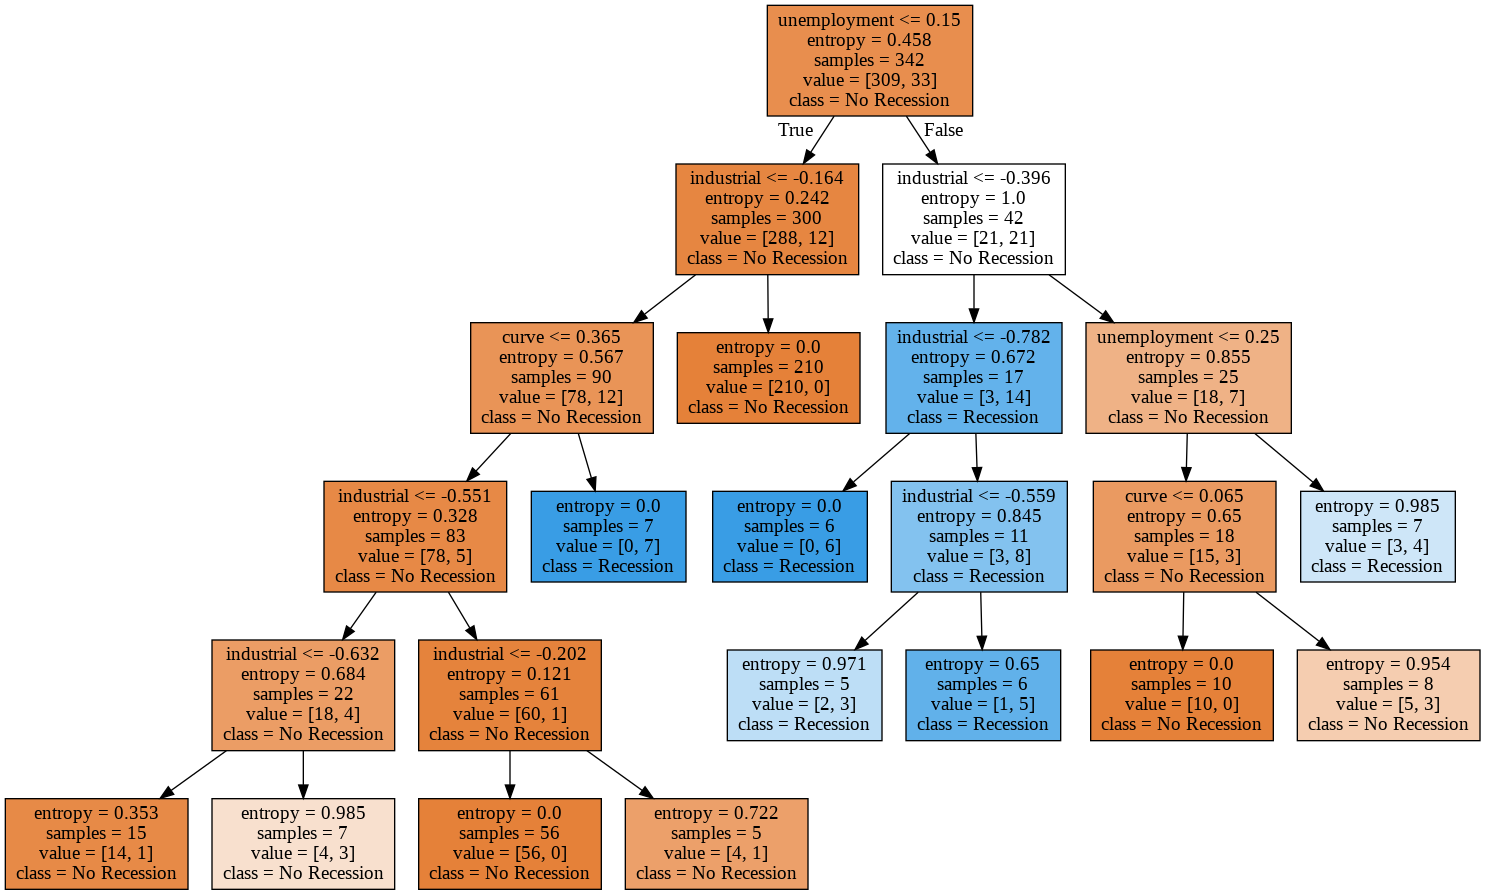

In [0]:
#Visualizing the decision tree classifier
import pydotplus
from IPython.display import Image
from sklearn import tree

dot_data = tree.export_graphviz(classifier_entropy, out_file=None, class_names=['No Recession', 'Recession'], feature_names=features.columns, filled=True)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [0]:
#Inferring the importance of each feature
print(features.columns)
print(classifier.feature_importances_)
print(classifier_entropy.feature_importances_)

Index(['curve', 'unemployment', 'industrial'], dtype='object')
[0.25197113 0.28941453 0.45861434]
[0.23661136 0.38019948 0.38318917]


# Decision Tree regression for quarterly percentage change in GDP

In [0]:
 #Create regression target dataframe
 targetvalue = gdp
 targetvalue.head()                                                                  

,A191RL1Q225SBEA
DATE,
1982-01-01,-6.1
1982-04-01,1.8
1982-07-01,-1.5
1982-10-01,0.2
1983-01-01,5.4


In [0]:
#Downsample features dataframe and convert it into a quarterly frequency
qfeatures = features.resample('1q', label='right').last()
qfeatures.head()

,curve,unemployment,industrial
DATE,,,
1982-03-31,0.40,0.1,-0.7318
1982-06-30,0.31,0.2,-0.3668
1982-09-30,0.09,0.3,-0.3033
1982-12-31,0.14,0.0,-0.5618
1983-03-31,-0.48,-0.1,0.5537


In [0]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split

regressor = DecisionTreeRegressor(random_state=1)
qfeatures_train, qfeatures_test, targetvalue_train, targetvalue_test = train_test_split(qfeatures, targetvalue, test_size = 0.25, random_state=1)
regressor.fit(qfeatures_train, targetvalue_train)
print("Training score:", regressor.score(qfeatures_train, targetvalue_train))
print("Testing score:", regressor.score(qfeatures_test, targetvalue_test))
print("Percentage change in GDP next quarter:", regressor.predict(lastknown))

Training score: 1.0
Testing score: -0.43677883272073736
Percentage change in GDP next quarter: [-2.1]


In [0]:
regressor_mae = DecisionTreeRegressor(criterion="mae", max_depth=5, random_state=1)
qfeatures_train, qfeatures_test, targetvalue_train, targetvalue_test = train_test_split(qfeatures, targetvalue, test_size = 0.25, random_state=0)
regressor_mae.fit(qfeatures_train, targetvalue_train)
print("Training score:", regressor_mae.score(qfeatures_train, targetvalue_train))
print("Testing score:", regressor_mae.score(qfeatures_test, targetvalue_test))
print("Percentage change in GDP next quarter:", regressor_mae.predict(lastknown))

Training score: 0.6083634214913769
Testing score: -0.6122259547383309
Percentage change in GDP next quarter: [-2.1]


# Visualize Decision Tree regressor

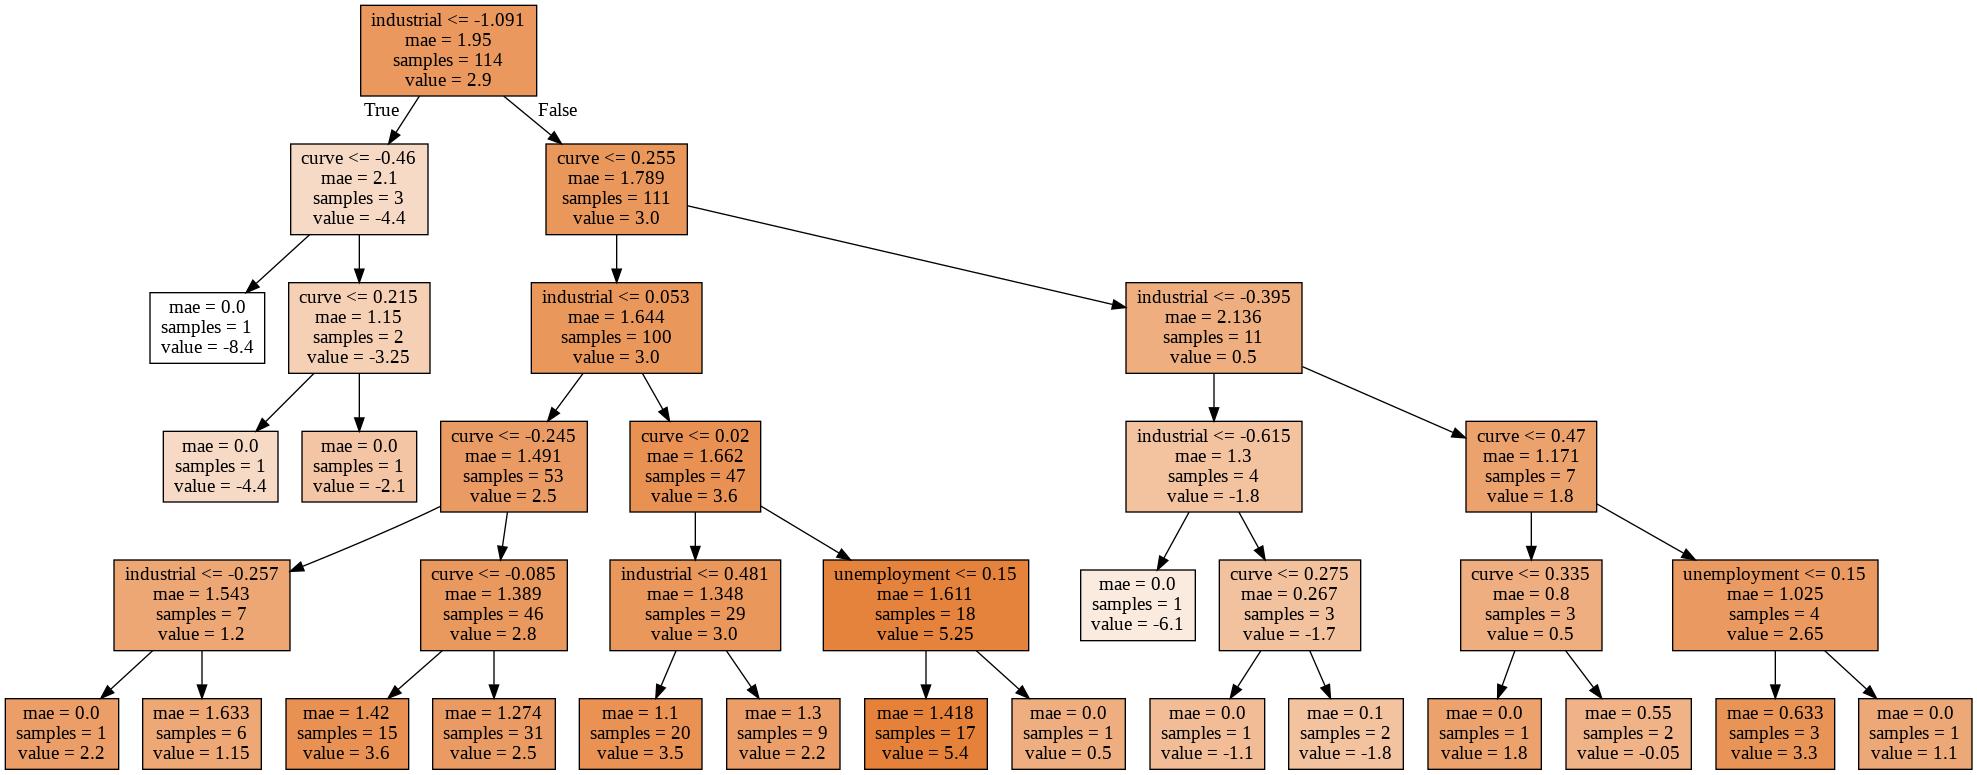

In [0]:
#Visualizing the decision tree regressor
import pydotplus
from IPython.display import Image
from sklearn import tree

dot_data = tree.export_graphviz(regressor_mae, out_file=None, feature_names=features.columns, filled=True)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [0]:
#Inferring the importance of each feature
print(features.columns)
print(regressor.feature_importances_)
print(regressor_mae.feature_importances_)

Index(['curve', 'unemployment', 'industrial'], dtype='object')
[0.35598727 0.17345248 0.47056025]
[0.41896362 0.07828004 0.50275634]
